# Нейронные сети



In [35]:
import wget 
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [36]:
directory = 'data'
url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
filename = wget.download(url)
os.rename(filename,os.path.join(directory,filename))

In [37]:
directory = 'data'
url2 = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
filename2 = wget.download(url2)
os.rename(filename2,os.path.join(directory,filename2))

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

### ReLU

In [10]:
X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X) #layers.py/gradient_check.py

Gradient check passed!


### Fully connected layer 

In [11]:
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B') 
#layers.py/gradient_check.py

Gradient check passed!
Gradient check passed!
Gradient check passed!


# Нейронная сеть

In [14]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])


check_model_gradient(model, train_X[:2], train_y[:2])
#model.py/gradient_check.py

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

## Регуляризация

In [17]:
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])
#layers.py/gradient_check.py

Checking gradient for W1
Gradient check passed!
Checking gradient for B1
Gradient check passed!
Checking gradient for W2
Gradient check passed!
Checking gradient for B2
Gradient check passed!


True

## Score

In [19]:
# Finally, implement predict function!

multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30])

#model.py/metrics.py

0.1

### Обучение модели

In [21]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

loss_history, train_history, val_history = trainer.fit()

#model.py/metrics.py/optim.py

Loss: 2.302705, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.300511, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302339, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301916, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301577, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301789, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302126, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303472, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302398, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302306, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303106, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303577, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302208, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301911, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301847, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302920, Train acc

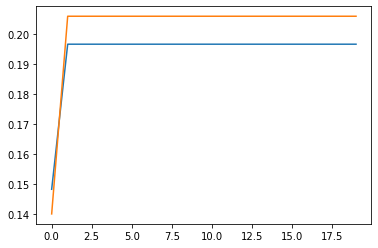

In [22]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшением процесса тренировки

## Уменьшение скорости обучения (learning rate decay)

In [24]:
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

#model.py/metrics.py/optim.py

Loss: 2.282026, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.220804, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.304563, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.332779, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265433, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290160, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281397, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271683, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.167511, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272940, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312080, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292346, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.305281, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.282768, Train acc

# Накопление импульса (Momentum SGD)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

In [27]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

#model.py/metrics.py/optim.py

Loss: 2.318773, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300463, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307396, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.284003, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.312351, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301691, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.307653, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.309887, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278664, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283250, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285759, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297113, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300555, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279871, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297075, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293508, Train acc

## Overfit на маленьком наборе данных

In [28]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

#model.py/metrics.py/optim.py

Loss: 2.331225, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.311917, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.309711, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.302350, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.290718, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.265667, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.180181, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.265704, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.124721, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.935802, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.895935, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.163137, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.727986, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.797636, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.336883, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.329628, Train acc

Loss: 1.149234, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.189256, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.168980, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.492293, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.072785, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.382982, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.546748, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.247645, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.398664, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.350665, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.436692, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.199931, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.265730, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.323854, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.189928, Train accuracy: 1.000000, val accuracy: 0.000000


## Подбор гиперпараметров

In [29]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.343795, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.335189, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.332387, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.296897, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.327147, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299080, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.300755, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.250714, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.206018, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.080976, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.040819, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.170397, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.150772, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.784525, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.465388, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.665627, Train acc

In [31]:
# Let's train the best one-hidden-layer network we can

learning_rates = 1e-4
reg_strength = 1e-3
learning_rate_decay = 0.999
hidden_layer_size = 128
num_epochs = 200
batch_size = 64

best_classifier = None
best_val_accuracy = None

loss_history = []
train_history = []
val_history = []

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = hidden_layer_size, 
                    reg = reg_strength)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate=learning_rates, num_epochs=num_epochs, 
                  batch_size=batch_size, learning_rate_decay=learning_rate_decay)

loss_history, train_history, val_history = trainer.fit()

#print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.302544, Train accuracy: 0.077000, val accuracy: 0.078000
Loss: 2.302596, Train accuracy: 0.193667, val accuracy: 0.204000
Loss: 2.302199, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301464, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301374, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301646, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301090, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301504, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300259, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301779, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301069, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299484, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301234, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298077, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.300449, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299050, Train acc

Loss: 2.294140, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281796, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271960, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289336, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.286378, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303881, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278980, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281212, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285344, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277575, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.285148, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272369, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278382, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.275291, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266817, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274101, Train acc

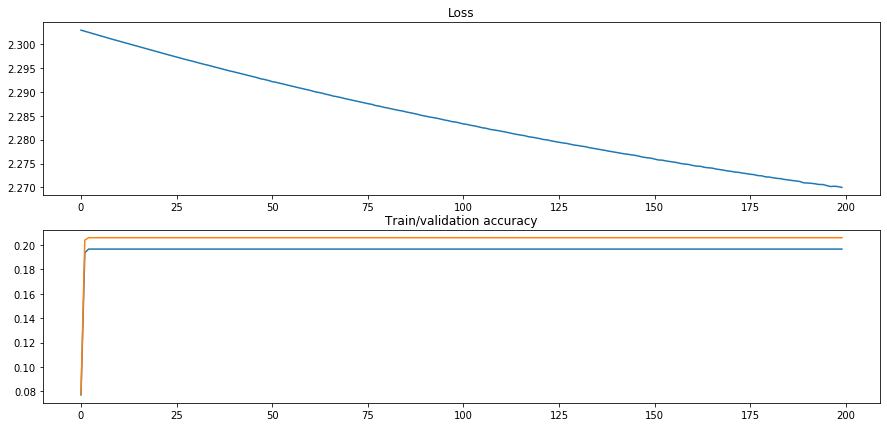

In [32]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Лучшая модель на тестовых данных

In [34]:
test_pred = model.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.182000
